In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pymc as pm
import scipy.stats as sps
sns.set()

In [2]:
# days with k homicides in UK
zeros = np.array([0] * 259)
ones = np.array([1] * 387)
twos = np.array([2] * 261)
threes = np.array([3] * 131)
fours = np.array([4] * 40)
fives = np.array([5] * 13)
six = np.array([6] * 3)

data = np.concatenate([zeros,ones,twos,threes,fours,fives,six])


In [3]:
data_mean = data.mean()
data_std = data.std()
print (data_mean)
print (data_std)

1.4122486288848264
1.171366125502726


In [4]:
samples = pm.rpoisson(data_mean,100000)

[24229 34448 24127 11617  4091  1163   258    56    10     1]
[ 0  1  2  3  4  5  6  7  8  9 10] [259 387 261 131  40  13   3   0   0   0]
[259 387 261 131  40  13   3   0   0   0]


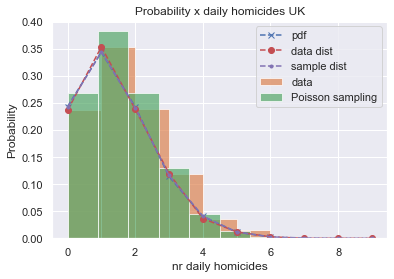

In [5]:
counts,bins = np.histogram(data,bins=range(0,11))
sample_counts,sample_bins=np.histogram(samples,bins=range(0,11))
print (sample_counts)
norm_sample_counts = sample_counts / sample_counts.sum()

x = range(7)
y = sps.poisson.pmf(x,data_mean)
plt.title('Probability x daily homicides UK')
plt.plot(x,y,'x--',label='pdf')
plt.hist(data,bins=6,density=True,alpha=0.7,label='data')
plt.hist(samples,bins=10,density=True,alpha=0.7,label='Poisson sampling')
print (bins,counts)
norm_counts = counts / counts.sum()
print (counts)
plt.plot(range(len(norm_counts)),norm_counts,'o--',label='data dist')
plt.plot(range(len(norm_sample_counts)),norm_sample_counts,'.--',label='sample dist')
plt.ylabel('Probability')
plt.xlabel('nr daily homicides')
plt.legend(loc='upper right')

In [6]:
scb = pd.read_csv('scb-dead_per_day.csv',sep=';',usecols=[1,2,3,4,5,6,7])
scb.index = pd.date_range('2020-01-01','2020-12-31')
#scb.drop(pd.Timestamp('2020-02-29'),inplace=True)
scb

,2015,2016,2017,2018,2019,2020,2015-2019
2020-01-01,295,245,339,275,300,254,291
2020-01-02,272,272,317,312,276,300,290
2020-01-03,281,293,310,295,271,256,290
2020-01-04,256,260,305,285,282,272,278
2020-01-05,268,260,304,291,275,265,280
...,...,...,...,...,...,...,...
2020-12-27,227,249,271,240,238,0,245
2020-12-28,274,262,273,261,215,0,257
2020-12-29,292,274,276,263,244,0,270
2020-12-30,283,307,275,232,226,0,265


In [7]:
scb.loc[:,:'2019'].sum()

2015    89947
2016    89019
2017    89742
2018    89672
2019    86150
dtype: int64

In [8]:
last_data_day = scb.loc[scb['2020'] == 0]
last_data_day = last_data_day.iloc[0].name
last_data_day = last_data_day - pd.DateOffset(days=1)
last_data_day

Timestamp('2020-07-03 00:00:00')

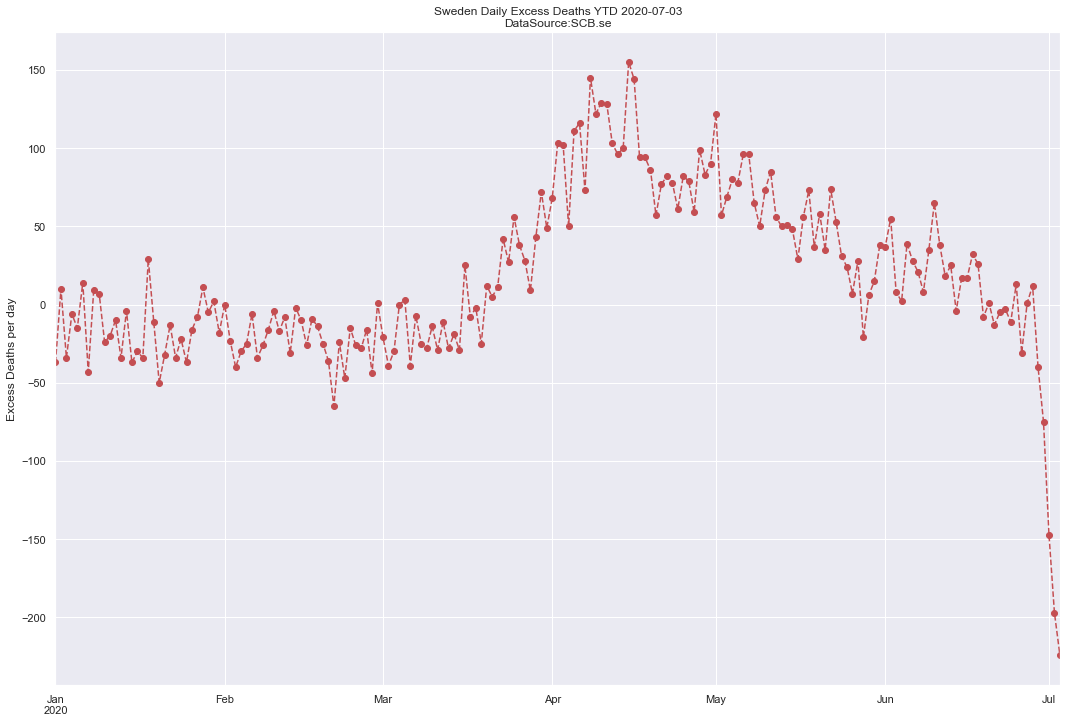

In [9]:
day_excess = scb['2020'][:last_data_day] - scb['2015-2019'][:last_data_day]
idx = day_excess.index.date
day_excess.plot(x=idx,figsize=(18,12),style='ro--',
               title='Sweden Daily Excess Deaths YTD {}\nDataSource:SCB.se'.format(last_data_day.date()))
plt.ylabel('Excess Deaths per day')

plt.savefig('scb_excess_deaths_per_day.jpg',format='jpg')

In [10]:
cumulative_until_last_day = scb[:last_data_day].sum()
cumulative_until_last_day['2020'] / cumulative_until_last_day['2015-2019']

1.0674409650924024

In [11]:
scb_weekly = scb.resample('W-TUE').sum()
print(scb_weekly.loc[:last_data_day].sum())
(scb_weekly.loc[:last_data_day,'2020'] - scb_weekly.loc[:last_data_day,'2015-2019']).sum()

2015         47095
2016         45168
2017         46605
2018         46831
2019         43648
2020         49788
2015-2019    46067
dtype: int64


3721

In [12]:
scb_weekly

,2015,2016,2017,2018,2019,2020,2015-2019
2020-01-07,1937,1846,2192,1998,1965,1878,1989
2020-01-14,1954,1904,2109,1941,1802,1867,1943
2020-01-21,1937,1969,2088,1945,1832,1790,1955
2020-01-28,1929,1977,1922,1928,1807,1794,1913
2020-02-04,1966,1931,1913,1854,1871,1794,1908
2020-02-11,1918,1913,1833,1983,1847,1771,1899
2020-02-18,2050,1783,2004,2024,1754,1823,1923
2020-02-25,2149,1874,2071,2116,1850,1774,2012
2020-03-03,1743,1806,1751,1877,1494,1751,1928
2020-03-10,2028,1897,1873,2221,1690,1831,1941


In [28]:
scb_monthly = scb.resample('M').sum()
scb_monthly['delta'] = scb_monthly['2020'] - scb_monthly['2015-2019']
scb_monthly['cumdelta'] = (scb_monthly['delta'].cumsum())
# last of feb not correct for delta - leap year
scb_monthly

,2015,2016,2017,2018,2019,2020,2015-2019,delta,cumdelta
2020-01-31,8637,8548,9101,8578,8174,8119,8611,-492,-492
2020-02-29,8067,7672,7875,8151,7294,7361,8007,-646,-1138
2020-03-31,8619,8009,8076,9210,7570,8362,8296,66,-1072
2020-04-30,7694,7406,7566,7615,7186,10360,7494,2866,1794
2020-05-31,7311,6991,7332,6778,6972,8694,7075,1619,3413
2020-06-30,6767,6542,6655,6499,6452,6892,6584,308,3721
2020-07-31,7036,7084,6778,7259,6723,117,6973,-6856,-3135
2020-08-31,6712,7005,6824,6791,6829,0,6831,-6831,-9966
2020-09-30,6916,6728,6762,6803,6674,0,6776,-6776,-16742
2020-10-31,7147,7357,7415,7276,7338,0,7309,-7309,-24051


In [29]:
data = scb_weekly.iloc[:,0:5]
#data = data.iloc[:9]
data.mean(axis=1)
data

,2015,2016,2017,2018,2019
2020-01-07,1937,1846,2192,1998,1965
2020-01-14,1954,1904,2109,1941,1802
2020-01-21,1937,1969,2088,1945,1832
2020-01-28,1929,1977,1922,1928,1807
2020-02-04,1966,1931,1913,1854,1871
2020-02-11,1918,1913,1833,1983,1847
2020-02-18,2050,1783,2004,2024,1754
2020-02-25,2149,1874,2071,2116,1850
2020-03-03,1743,1806,1751,1877,1494
2020-03-10,2028,1897,1873,2221,1690


In [30]:
data_min = data.min(axis=1)
data_max = data.max(axis=1)

print (data.mean().mean())

1677.4716981132074


[9.23891299e-03 4.79895459e+02 1.16082074e+03 2.30969417e+03
 1.74094261e+04]


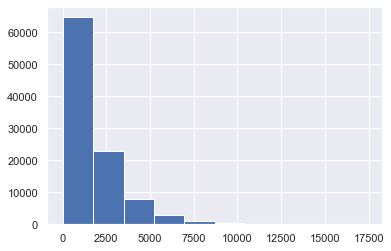

In [16]:
test_lambda = pm.rexponential(1/ data.mean().mean(),100000)
plt.hist(test_lambda)
print (np.percentile(test_lambda,[0,25,50,75,100]))

In [17]:
walk = 50000
burnin = 20000
thin = 2


res_array = np.zeros((len(data),3))
dist_array = np.zeros((len(data),(walk - burnin) // thin))

for i in range(len(data)):
    print ('\n++++++++++++++++++++ processing day ++++++++++++++++++++', i)
    print (data.iloc[i,:])
    print (data.iloc[i,:].mean())
    
    lambda_ = pm.Exponential('lambda',1/ data.iloc[i,:].mean())
    lkh  = pm.Poisson('lkh',lambda_,observed=True,value=data.iloc[i,:])
    model = pm.Model([lambda_,lkh])
    mcmc = pm.MCMC(model)
    sample = mcmc.sample(walk,burnin,thin)
    post = mcmc.trace(lambda_)[:]   
        
    res_array[i,0] = post.min()
    res_array[i,1] = post.mean()
    res_array[i,2] = post.max()
    
    dist_array[i,:] = post
                     
    


++++++++++++++++++++ processing day ++++++++++++++++++++ 0
2015    1937
2016    1846
2017    2192
2018    1998
2019    1965
Name: 2020-01-07 00:00:00, dtype: int64
1987.6
 [-----------------100%-----------------] 50000 of 50000 complete in 2.1 sec
++++++++++++++++++++ processing day ++++++++++++++++++++ 1
2015    1954
2016    1904
2017    2109
2018    1941
2019    1802
Name: 2020-01-14 00:00:00, dtype: int64
1942.0
 [-----------------100%-----------------] 50000 of 50000 complete in 2.3 sec
++++++++++++++++++++ processing day ++++++++++++++++++++ 2
2015    1937
2016    1969
2017    2088
2018    1945
2019    1832
Name: 2020-01-21 00:00:00, dtype: int64
1954.2
 [-----------------100%-----------------] 50000 of 50000 complete in 2.1 sec
++++++++++++++++++++ processing day ++++++++++++++++++++ 3
2015    1929
2016    1977
2017    1922
2018    1928
2019    1807
Name: 2020-01-28 00:00:00, dtype: int64
1912.6
 [-----------------100%-----------------] 50000 of 50000 complete in 2.2 sec
+++++++

 [-----------------100%-----------------] 50000 of 50000 complete in 3.9 sec
++++++++++++++++++++ processing day ++++++++++++++++++++ 33
2015    1574
2016    1555
2017    1591
2018    1486
2019    1542
Name: 2020-08-25 00:00:00, dtype: int64
1549.6
 [-----------------100%-----------------] 50000 of 50000 complete in 4.3 sec
++++++++++++++++++++ processing day ++++++++++++++++++++ 34
2015    1477
2016    1628
2017    1518
2018    1570
2019    1642
Name: 2020-09-01 00:00:00, dtype: int64
1567.0
 [-----------------100%-----------------] 50000 of 50000 complete in 3.4 sec
++++++++++++++++++++ processing day ++++++++++++++++++++ 35
2015    1628
2016    1650
2017    1584
2018    1632
2019    1441
Name: 2020-09-08 00:00:00, dtype: int64
1587.0
 [-----------------100%-----------------] 50000 of 50000 complete in 2.3 sec
++++++++++++++++++++ processing day ++++++++++++++++++++ 36
2015    1565
2016    1507
2017    1601
2018    1518
2019    1559
Name: 2020-09-15 00:00:00, dtype: int64
1550.0
 [--

In [18]:
dist_array

array([[1974.84345189, 1974.84345189, 1949.06496875, ..., 2024.89416424,
        2024.89416424, 1982.87627637],
       [1906.24440713, 1921.28536179, 1962.23451151, ..., 1954.12201086,
        1946.24480398, 1946.24480398],
       [1958.40637978, 1958.40637978, 1958.40637978, ..., 1960.67094438,
        1969.55998007, 1969.55998007],
       ...,
       [1803.98629222, 1793.70470582, 1793.70470582, ..., 1767.81445975,
        1767.81445975, 1767.81445975],
       [1831.7661252 , 1831.7661252 , 1831.7661252 , ..., 1831.09107247,
        1831.09107247, 1831.16871083],
       [ 525.21969613,  525.21969613,  525.21969613, ...,  533.86842058,
         534.44547484,  540.87105164]])

In [19]:
N = 1000

lambdas_per_week = np.zeros((len(dist_array),N))
samples_per_week = np.zeros((len(dist_array),N))

for week in range(len(dist_array)):
    lambdas_per_week[week] = np.random.choice(dist_array[week],replace=True,size=N)
    samples_per_week[week] = pm.rpoisson(lambdas_per_week[week],size=N)

In [20]:
print (lambdas_per_week[:5])
samples_per_week[:5]

[[1979.94967867 1978.83962898 1975.4438039  ... 2006.62567401
  1976.97966567 1969.69681733]
 [1982.92761372 1970.99017973 1927.63292814 ... 1951.39865642
  1951.78437014 1937.87093636]
 [1960.64392173 1964.54187688 1953.49398205 ... 1972.21422142
  1966.27174965 1969.85659343]
 [1901.67994751 1970.99564022 1952.06903172 ... 1891.03824335
  1902.99640465 1924.99334912]
 [1911.31839405 1904.40859874 1866.57253511 ... 1900.55196886
  1903.84385314 1886.79067628]]


array([[1976., 2059., 1996., ..., 1984., 2061., 2007.],
       [1954., 1882., 1903., ..., 1903., 1968., 1926.],
       [1854., 1958., 1902., ..., 1959., 1952., 1936.],
       [1916., 2014., 1954., ..., 1936., 1908., 1922.],
       [1865., 1865., 1838., ..., 1919., 1947., 1863.]])

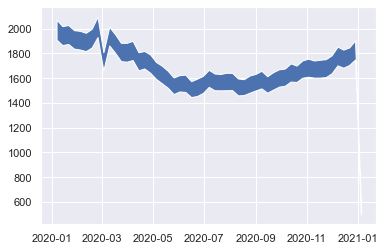

In [21]:
ci_samples = np.percentile(samples_per_week,[5.5,94.5],axis=1)
ci_samples

plt.fill_between(scb_weekly.index,ci_samples[0],ci_samples[1])

In [22]:
res_array

array([[1914.42355552, 1987.37939093, 2061.11915862],
       [1876.12287536, 1942.16130931, 2013.57717265],
       [1881.65655049, 1954.41052135, 2034.6007679 ],
       [1822.26462736, 1912.3984653 , 1987.16255696],
       [1838.08685422, 1907.10425892, 1973.26575362],
       [1834.03793098, 1898.46080068, 1966.26953403],
       [1848.68185466, 1923.0733423 , 1997.25590267],
       [1935.03570041, 2012.26129972, 2082.82536307],
       [1660.68444503, 1734.35751233, 1812.51313653],
       [1866.62944225, 1941.840947  , 2013.12534852],
       [1808.62470135, 1880.67770391, 1959.14250236],
       [1742.14279656, 1812.42064158, 1884.45932964],
       [1731.96271194, 1808.8741468 , 1885.45461931],
       [1749.25369632, 1822.74363897, 1895.97518311],
       [1668.91245011, 1736.59765988, 1812.31289228],
       [1678.8768213 , 1746.92787079, 1824.89440236],
       [1645.46584267, 1717.48956376, 1791.48189881],
       [1603.16411222, 1661.95105614, 1734.85587395],
       [1565.70353715, 1628.

In [23]:
errors_low = np.abs(res_array[:,1] - res_array[:,0])
errors_low = errors_low[:-1]
errors_high = np.abs(res_array[:,1] - res_array[:,2]) 
errors_high = errors_high[:-1]
print (errors_low)
print (errors_high)

errors = np.array((errors_low,errors_high))
errors

[72.95583541 66.03843395 72.75397087 90.13383794 69.0174047  64.4228697
 74.39148764 77.22559931 73.6730673  75.21150475 72.05300256 70.27784502
 76.91143486 73.48994265 67.68520977 68.05104949 72.0237211  58.78694392
 62.72481486 58.7002416  66.9087229  62.44954603 68.53804021 62.58894057
 68.19653935 69.52283251 72.33493116 65.0498355  67.14724264 65.71040406
 58.83003288 63.49285561 71.28831493 70.54098828 71.07595535 59.33447131
 60.81550686 65.28039819 74.51673468 78.79374631 72.23009299 65.62876164
 70.57885231 65.6866428  60.41082288 84.95197871 67.78570519 75.63975006
 65.63294209 71.40963811 64.1983135  67.33717972]
[73.73976769 71.41586335 80.19024654 74.76409167 66.16149471 67.80873335
 74.18256037 70.56406335 78.1556242  71.28440152 78.46479845 72.03868806
 76.58047251 73.23154414 75.71523241 77.96653157 73.99233505 72.90481781
 66.12116346 65.53692126 64.68907871 88.67969286 65.93491908 69.70106771
 64.47501121 69.22608059 67.41266648 68.69576998 74.31368963 82.18967351
 6

array([[72.95583541, 66.03843395, 72.75397087, 90.13383794, 69.0174047 ,
        64.4228697 , 74.39148764, 77.22559931, 73.6730673 , 75.21150475,
        72.05300256, 70.27784502, 76.91143486, 73.48994265, 67.68520977,
        68.05104949, 72.0237211 , 58.78694392, 62.72481486, 58.7002416 ,
        66.9087229 , 62.44954603, 68.53804021, 62.58894057, 68.19653935,
        69.52283251, 72.33493116, 65.0498355 , 67.14724264, 65.71040406,
        58.83003288, 63.49285561, 71.28831493, 70.54098828, 71.07595535,
        59.33447131, 60.81550686, 65.28039819, 74.51673468, 78.79374631,
        72.23009299, 65.62876164, 70.57885231, 65.6866428 , 60.41082288,
        84.95197871, 67.78570519, 75.63975006, 65.63294209, 71.40963811,
        64.1983135 , 67.33717972],
       [73.73976769, 71.41586335, 80.19024654, 74.76409167, 66.16149471,
        67.80873335, 74.18256037, 70.56406335, 78.1556242 , 71.28440152,
        78.46479845, 72.03868806, 76.58047251, 73.23154414, 75.71523241,
        77.96653

2020-01-07   -111
2020-01-14    -76
2020-01-21   -165
2020-01-28   -119
2020-02-04   -114
2020-02-11   -128
2020-02-18   -100
2020-02-25   -238
2020-03-03   -177
2020-03-10   -110
2020-03-17    -99
2020-03-24     70
2020-03-31    295
2020-04-07    623
2020-04-14    823
2020-04-21    707
2020-04-28    540
2020-05-05    579
2020-05-12    521
2020-05-19    344
2020-05-26    282
2020-06-02    158
2020-06-09    141
2020-06-16    176
2020-06-23     30
2020-06-30   -131
Freq: W-TUE, dtype: int64
2020-01-07    -111
2020-01-14    -187
2020-01-21    -352
2020-01-28    -471
2020-02-04    -585
2020-02-11    -713
2020-02-18    -813
2020-02-25   -1051
2020-03-03   -1228
2020-03-10   -1338
2020-03-17   -1437
2020-03-24   -1367
2020-03-31   -1072
2020-04-07    -449
2020-04-14     374
2020-04-21    1081
2020-04-28    1621
2020-05-05    2200
2020-05-12    2721
2020-05-19    3065
2020-05-26    3347
2020-06-02    3505
2020-06-09    3646
2020-06-16    3822
2020-06-23    3852
2020-06-30    3721
Freq: W-TUE,

Text(0, 0.5, 'Number of Excess Deaths')

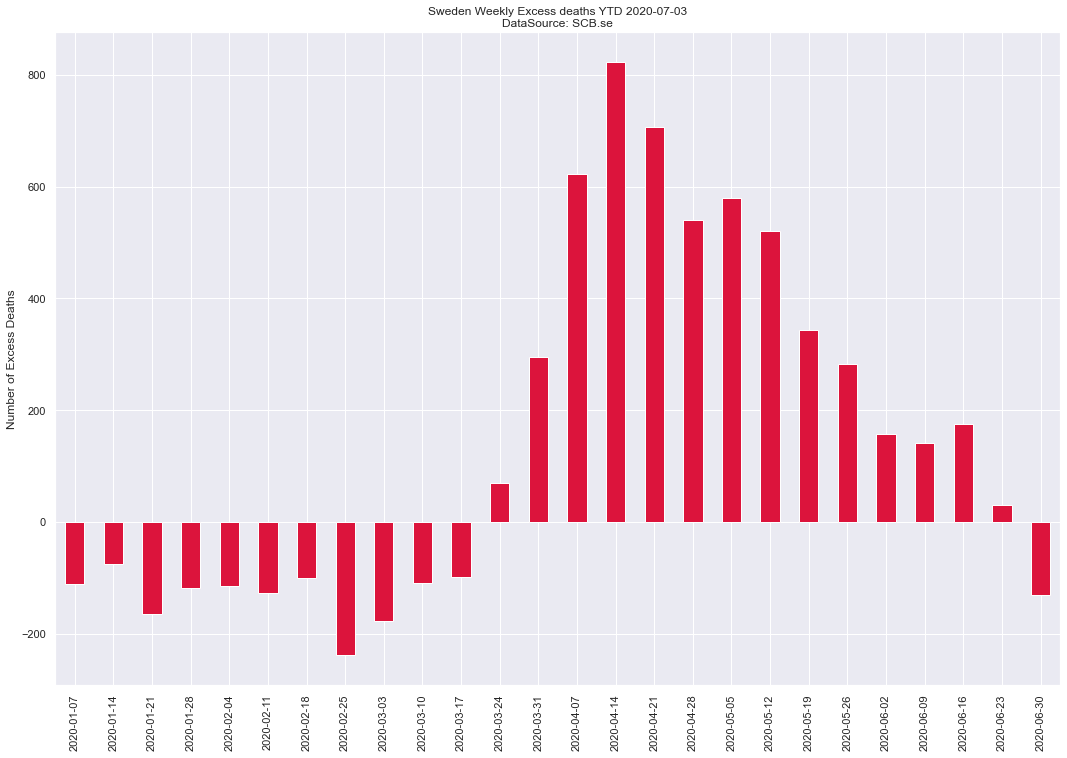

In [24]:

excess = scb_weekly.loc[:last_data_day,'2020'] - scb_weekly.loc[:last_data_day,'2015-2019']
print (excess)
current_excess = excess.cumsum()
print (current_excess)
excess.index = excess.index.date
excess.plot.bar(x=excess.index,title='Sweden Weekly Excess deaths YTD {}\nDataSource: SCB.se'.format(last_data_day.date()),
                y=excess,
                figsize=(18,12),
                color='crimson')

plt.ylabel('Number of Excess Deaths')

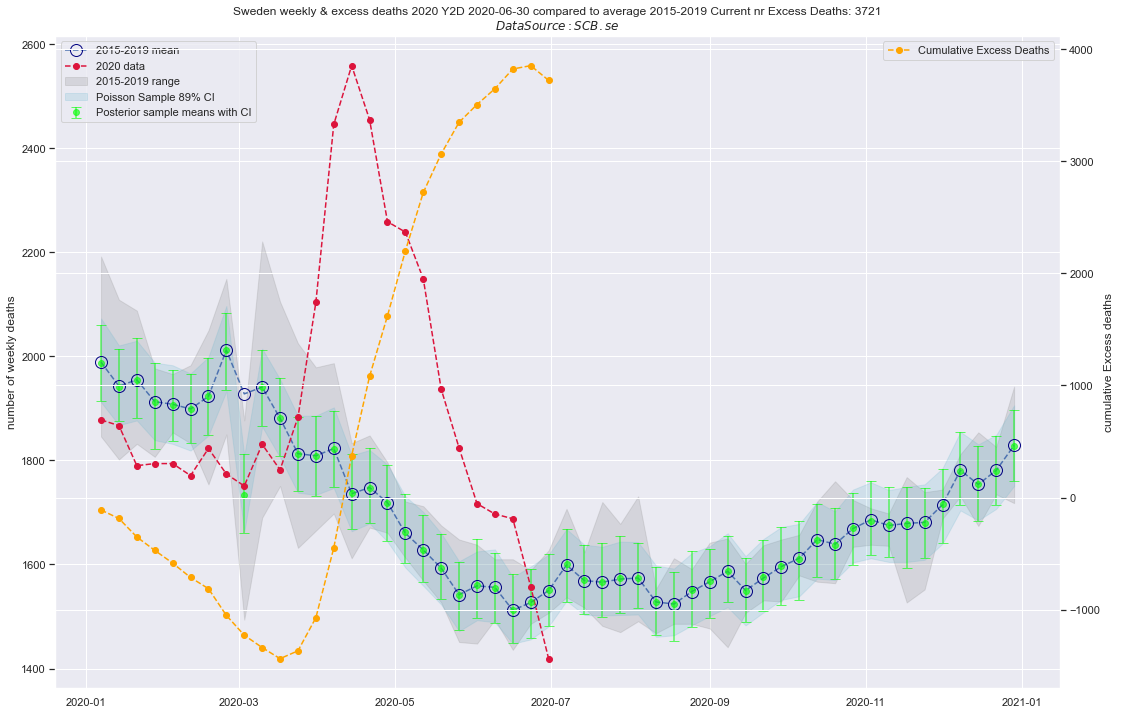

In [31]:
plt.figure(figsize=(18,12))
plt.title('Sweden weekly & excess deaths 2020 Y2D '\
          '{} compared to average 2015-2019 Current nr Excess Deaths: {}\n$Data Source: SCB.se$'.format(
    excess.index[-1],current_excess[-1]))
ax = plt.gca()
ax2 = plt.twinx()

ax.errorbar(scb_weekly.index[:len(data) - 1],res_array[:-1,1],yerr=errors,
             fmt='o',capsize=5,color='lime',alpha=0.6,label='Posterior sample means with CI')

ax.plot(scb_weekly.index[:len(data) -1],scb_weekly['2015-2019'][:-1],'o--',
        markerfacecolor='none',markeredgecolor='navy',markersize=12,
        label='2015-2019 mean')

ax.plot(scb_weekly[:last_data_day].index,scb_weekly.loc[:last_data_day,'2020'],'o--',
         color='crimson',label='2020 data')

ax.fill_between(scb_weekly.index[:len(data) -1],y1=data_min[:-1],y2=data_max[:-1],color='grey',
                 alpha=0.2,label='2015-2019 range')

ax.fill_between(scb_weekly.index[:len(data) -1],y1=ci_samples[0][:-1],y2=ci_samples[1][:-1],color='c',
                 alpha=0.2,label='Poisson Sample 89% CI')



ax2.plot(excess.index,excess.cumsum(),'o--',ls='dashed',color='orange',label='Cumulative Excess Deaths')
ax.set_ylabel('number of weekly deaths')
ax2.set_ylabel('cumulative Excess deaths')
ax.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.savefig('scb_poisson_weekly.jpg',format='jpg')

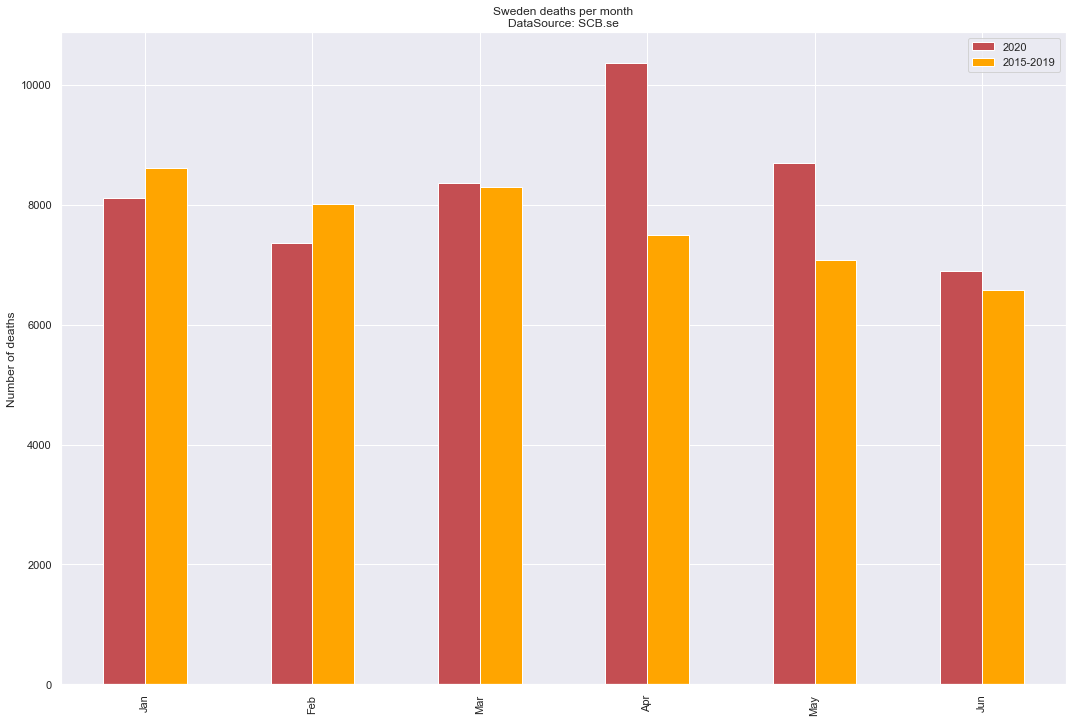

In [33]:
#scb_monthly.index = scb_monthly.index.date
scb_monthly[['2020','2015-2019']][:pd.Timestamp('2020-06-30')].plot.bar(color=['r','orange'],
                                                                        title='Sweden deaths per month\nDataSource: SCB.se',figsize=(18,12))
plt.ylabel('Number of deaths')
plt.xticks(range(len(scb_monthly[:pd.Timestamp('2020-06-30')])),['Jan','Feb','Mar','Apr','May','Jun'])
plt.savefig('scb_monthly_deaths.jpg',format='jpg')